# Exploratory Analysis of the M5 Dataset of Walmart Goods Sales

In [2]:
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import plotly as px
import plotly.express as px
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# geo location
from geopy.geocoders import Nominatim
import geopandas as gpd

# utilities
import time
import itertools
import math
import re
import io
import base64

# stats models
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
import sys
sys.executable
# HM-personalized-recommender/.venv/bin/python'
%pip install geopy seaborn plotly geopandas statsmodels


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


some ideas:
1. geo cluster store locations
2. embedding the product id, eg. diaper 1 and 2 brands should be closer

## Load the raw dataset

In [4]:
!ls

01_exploratory_analysis.ipynb LSTM_model_implementation.md
CIV_definition.md


In [5]:
from pathlib import Path
import pandas as pd

# Resolve data/raw whether notebook is run from repo root or from notebooks/
cwd = Path.cwd()
raw_dir = (cwd / "data" / "raw") if (cwd / "data" / "raw").exists() else (cwd.parent / "data" / "raw")

# Read all CSVs and create variables named after the filenames (without .csv)
dataframes = {}
for fp in sorted(raw_dir.glob("*.csv")):
    var_name = fp.stem  # e.g., "calendar"
    df = pd.read_csv(fp)
    dataframes[var_name] = df
    globals()[var_name] = df  # creates calendar, sell_prices, etc.

list(dataframes.keys())


['calendar',
 'sales_train_evaluation',
 'sales_train_validation',
 'sample_submission',
 'sell_prices']

## 1. Calendar
Description: Contains information about the dates on which the products are sold.
- Total of 6 years: 2011 to 2016. 2011-01-29 to 2016-06-19
- Total number of days 1969, which is 5.39 years (365 days). 2011 -337 days, 2012~2015 full year, 2016-171 days.
- calendar_event_agg df contains the 35 unique combinations of events happens

In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [8]:
cal = calendar.copy()
cal["date"] = pd.to_datetime(cal["date"])

# Use 'weekday' if present, else fallback to numeric 'wday'
weekday_col = "weekday" if "weekday" in cal.columns else "wday"

# Treat "unique months" as unique Year-Month buckets
cal["year_month"] = cal["date"].dt.to_period("M").astype(str)
cal["ymd"] = cal["date"].dt.strftime("%Y-%m-%d")

group_cols = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]

calendar_event_agg = (
    cal.groupby(group_cols, dropna=False)
      .agg(
          total_unique_days=("date", "nunique"),
          total_unique_years=("year", "nunique"),
          total_unique_months=("year_month", "nunique"),
          year_month_day_list=("ymd", lambda s: sorted(s.dropna().unique().tolist())),
          weekday_list=(weekday_col, lambda s: sorted(s.dropna().unique().tolist())),
      )
      .reset_index()
)

calendar_event_agg


,event_name_1,event_type_1,event_name_2,event_type_2,total_unique_days,total_unique_years,total_unique_months,year_month_day_list,weekday_list
0,Chanukah End,Religious,NaN,NaN,5,5,5,"[2011-12-28, 2012-12-16, 2013-12-05, 2014-12-2...","[Monday, Sunday, Thursday, Wednesday]"
1,Christmas,National,NaN,NaN,5,5,5,"[2011-12-25, 2012-12-25, 2013-12-25, 2014-12-2...","[Friday, Sunday, Thursday, Tuesday, Wednesday]"
2,Cinco De Mayo,Cultural,NaN,NaN,5,5,5,"[2011-05-05, 2012-05-05, 2014-05-05, 2015-05-0...","[Monday, Saturday, Thursday, Tuesday]"
3,ColumbusDay,National,NaN,NaN,5,5,5,"[2011-10-10, 2012-10-08, 2013-10-14, 2014-10-1...",[Monday]
4,Easter,Cultural,OrthodoxEaster,Religious,1,1,1,[2014-04-20],[Sunday]
5,Easter,Cultural,NaN,NaN,4,4,4,"[2012-04-08, 2013-03-31, 2015-04-05, 2016-03-27]",[Sunday]
6,Eid al-Fitr,Religious,NaN,NaN,5,5,5,"[2011-08-31, 2012-08-19, 2013-08-08, 2014-07-2...","[Saturday, Sunday, Thursday, Tuesday, Wednesday]"
7,EidAlAdha,Religious,NaN,NaN,5,5,5,"[2011-11-07, 2012-10-26, 2013-10-15, 2014-10-0...","[Friday, Monday, Saturday, Thursday, Tuesday]"
8,Father's day,Cultural,NaN,NaN,4,4,4,"[2011-06-19, 2012-06-17, 2013-06-16, 2015-06-21]",[Sunday]
9,Halloween,Cultural,NaN,NaN,5,5,5,"[2011-10-31, 2012-10-31, 2013-10-31, 2014-10-3...","[Friday, Monday, Saturday, Thursday, Wednesday]"


In [9]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## Sales Train Validation
Description: contains the historical daily unit sales per product per store [d_1, d_1913]

- 1913 is less than the total calendar days 1969, indicating 1-1913 are for training, 1914-1941 (forecast the next 28 days of sale) 
- Total of 30490 rows
    - 3049 unique item_id
    - 7 unique dept_id ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']
    - 3 unique cat_id ['HOBBIES', 'HOUSEHOLD', 'FOODS']
    - 10 unique store_id ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

In [10]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [11]:
sales_item_counts = (
    sales_train_validation
    .groupby(["dept_id", "cat_id", "store_id", "state_id"], dropna=False)
    .agg(unique_item_id_count=("item_id", "nunique"))
    .reset_index()
)

sales_item_counts


,dept_id,cat_id,store_id,state_id,unique_item_id_count
0,FOODS_1,FOODS,CA_1,CA,216
1,FOODS_1,FOODS,CA_2,CA,216
2,FOODS_1,FOODS,CA_3,CA,216
3,FOODS_1,FOODS,CA_4,CA,216
4,FOODS_1,FOODS,TX_1,TX,216
...,...,...,...,...,...
65,HOUSEHOLD_2,HOUSEHOLD,TX_2,TX,515
66,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,515
67,HOUSEHOLD_2,HOUSEHOLD,WI_1,WI,515
68,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,515


In [12]:
sales_train_validation.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [13]:
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [14]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Join the items sales dataset with sales price and dates

Answer the following questions:
1. Total sales units, sales unique items, sales $ per day
    -  per category, per state, per location drill down




In [15]:
"""
prompts:
Take `sales_train_valiation` as backbone, keep "dept_id", "cat_id", "store_id", "state_id", "item_id", flatten the d_{number} columns into rows and fill each row with the sale units values in the original column. So the new sales_backbone dataframe would contains the following column:
"dept_id", "cat_id", "store_id", "state_id", "date", "sales_unit". where date takes values from d_1 to d_1913.
"""
# Backbone columns to keep
id_cols = ["dept_id", "cat_id", "store_id", "state_id", "item_id"]

day_cols = [c for c in sales_train_validation.columns if c.startswith("d_")]

sales_backbone = (
    sales_train_validation[id_cols + day_cols]
    .melt(id_vars=id_cols, value_vars=day_cols, var_name="date", value_name="sales_unit")
    .groupby(id_cols + ["date"], dropna=False, as_index=False)["sales_unit"]
    .sum()
)

# optional sanity check
sales_backbone.duplicated(subset=id_cols + ["date"]).sum()

sales_backbone.head()


,dept_id,cat_id,store_id,state_id,item_id,date,sales_unit
0,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1,3
1,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_10,0
2,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_100,0
3,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1000,1
4,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1001,0


In [16]:
sales_backbone_orignal_rows = sales_backbone.shape[0] # keep this for post-join guardrails

In [17]:
sales_backbone_orignal_rows

58327370

### sales backbone flatten validation passed

In [18]:

sales_backbone.loc[(sales_backbone['item_id']=='HOBBIES_1_001') & (sales_backbone['date'] == 'd_1905')]

,dept_id,cat_id,store_id,state_id,item_id,date,sales_unit
27490817,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_001,d_1905,3
28286625,HOBBIES_1,HOBBIES,CA_2,CA,HOBBIES_1_001,d_1905,0
29082433,HOBBIES_1,HOBBIES,CA_3,CA,HOBBIES_1_001,d_1905,2
29878241,HOBBIES_1,HOBBIES,CA_4,CA,HOBBIES_1_001,d_1905,0
30674049,HOBBIES_1,HOBBIES,TX_1,TX,HOBBIES_1_001,d_1905,0
31469857,HOBBIES_1,HOBBIES,TX_2,TX,HOBBIES_1_001,d_1905,0
32265665,HOBBIES_1,HOBBIES,TX_3,TX,HOBBIES_1_001,d_1905,3
33061473,HOBBIES_1,HOBBIES,WI_1,WI,HOBBIES_1_001,d_1905,0
33857281,HOBBIES_1,HOBBIES,WI_2,WI,HOBBIES_1_001,d_1905,1
34653089,HOBBIES_1,HOBBIES,WI_3,WI,HOBBIES_1_001,d_1905,1


In [19]:
sales_train_validation.loc[sales_train_validation['item_id'] == 'HOBBIES_1_001'][["dept_id", "cat_id", "store_id", "state_id", "d_1905"]]

,dept_id,cat_id,store_id,state_id,d_1905
0,HOBBIES_1,HOBBIES,CA_1,CA,3
3049,HOBBIES_1,HOBBIES,CA_2,CA,0
6098,HOBBIES_1,HOBBIES,CA_3,CA,2
9147,HOBBIES_1,HOBBIES,CA_4,CA,0
12196,HOBBIES_1,HOBBIES,TX_1,TX,0
15245,HOBBIES_1,HOBBIES,TX_2,TX,0
18294,HOBBIES_1,HOBBIES,TX_3,TX,3
21343,HOBBIES_1,HOBBIES,WI_1,WI,0
24392,HOBBIES_1,HOBBIES,WI_2,WI,1
27441,HOBBIES_1,HOBBIES,WI_3,WI,1


In [20]:
# replace d_{n} with data
# rename correctly
sales_backbone = sales_backbone.rename(columns={"date": "d"})

# join on d
sales_backbone = sales_backbone.merge(calendar, on="d", how="left")

# row count should not change with a left join (calendar has unique d)
assert sales_backbone.shape[0] == sales_backbone_orignal_rows


In [21]:
sales_backbone.head()

,dept_id,cat_id,store_id,state_id,item_id,d,sales_unit,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1,3,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_10,0,2011-02-07,11102,Monday,3,2,2011,NaN,NaN,NaN,NaN,1,1,0
2,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_100,0,2011-05-08,11115,Sunday,2,5,2011,Mother's day,Cultural,NaN,NaN,1,0,1
3,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1000,1,2013-10-24,11339,Thursday,6,10,2013,NaN,NaN,NaN,NaN,0,0,0
4,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1001,0,2013-10-25,11339,Friday,7,10,2013,NaN,NaN,NaN,NaN,0,0,0


## Add Sales Price

In [23]:
#
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [24]:
sales_backbone.head()

,dept_id,cat_id,store_id,state_id,item_id,d,sales_unit,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1,3,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_10,0,2011-02-07,11102,Monday,3,2,2011,NaN,NaN,NaN,NaN,1,1,0
2,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_100,0,2011-05-08,11115,Sunday,2,5,2011,Mother's day,Cultural,NaN,NaN,1,0,1
3,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1000,1,2013-10-24,11339,Thursday,6,10,2013,NaN,NaN,NaN,NaN,0,0,0
4,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1001,0,2013-10-25,11339,Friday,7,10,2013,NaN,NaN,NaN,NaN,0,0,0


In [25]:
sales_backbone = sales_backbone.merge(sell_prices, on=['store_id', 'item_id','wm_yr_wk'], how='left')
# row count should not change with a left join (calendar has unique d)
assert sales_backbone.shape[0] == sales_backbone_orignal_rows

In [26]:
# Time series features (item-store-day level)
# Note: rolling means use only *past* days (shift(1)) to avoid leakage.
sales_backbone = sales_backbone.sort_values(["store_id", "item_id", "date"]).reset_index(drop=True)

group_keys = ["store_id", "item_id"]

# Prices are weekly in M5; forward-fill within each item-store series so daily lags/rolls work.
sales_backbone["sell_price_filled"] = sales_backbone.groupby(group_keys, sort=False)["sell_price"].ffill()

lags = [1, 7, 14, 28]
for lag in lags:
    sales_backbone[f"sales_unit_lag_{lag}"] = sales_backbone.groupby(group_keys, sort=False)["sales_unit"].shift(lag)
    sales_backbone[f"sell_price_lag_{lag}"] = sales_backbone.groupby(group_keys, sort=False)["sell_price_filled"].shift(lag)

windows = [7, 28]
for window in windows:
    sales_backbone[f"sales_unit_roll_mean_{window}"] = (
        sales_backbone.groupby(group_keys, sort=False)["sales_unit"]
        .transform(lambda s: s.shift(1).rolling(window, min_periods=window).mean())
    )
    sales_backbone[f"sell_price_roll_mean_{window}"] = (
        sales_backbone.groupby(group_keys, sort=False)["sell_price_filled"]
        .transform(lambda s: s.shift(1).rolling(window, min_periods=window).mean())
    )

feature_cols = (
    [f"sales_unit_lag_{l}" for l in lags]
    + [f"sell_price_lag_{l}" for l in lags]
    + [f"sales_unit_roll_mean_{w}" for w in windows]
    + [f"sell_price_roll_mean_{w}" for w in windows]
)
sales_backbone[["store_id", "item_id", "date", "sales_unit", "sell_price"] + feature_cols].head()

,store_id,item_id,date,sales_unit,sell_price,sales_unit_lag_1,sales_unit_lag_7,sales_unit_lag_14,sales_unit_lag_28,sell_price_lag_1,sell_price_lag_7,sell_price_lag_14,sell_price_lag_28,sales_unit_roll_mean_7,sales_unit_roll_mean_28,sell_price_roll_mean_7,sell_price_roll_mean_28
0,CA_1,FOODS_1_001,2011-01-29,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1,FOODS_1_001,2011-01-30,0,2.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1,FOODS_1_001,2011-01-31,0,2.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1,FOODS_1_001,2011-02-01,1,2.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1,FOODS_1_001,2011-02-02,4,2.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##
Deliverable: clean panel + rolling split function + synthetic OOS.

1. Load + build panel
    item-store-day sales
    merge calendar + price

2. Create time features
    day-of-week, week-of-year, holiday flags
    lags: 1, 7, 14, 28
    rolling means: 7/28

3. Simulate stockouts (important for CIV story)
Create an OOS indicator oos_t:

    Start with random OOS at low rate (e.g., 3–8%)

Add “realism”: higher probability of OOS during promo/holiday or high-demand periods
Then create observed sales:

    y_obs = y_true if in stock

    y_obs = 0 (or capped at a small number) if OOS

Also store:

    is_censored = oos_t (so you can mask loss later)

Rolling backtest split
Implement something like:

Train: days 1..T, Validate: next 28 days
Slide forward 28 days, repeat 3–5 folds

In [28]:
# Time series features (item-store-day level)
# Rolling means use only *past* days (shift(1)) to avoid leakage.

# Ensure date is datetime
sales_backbone["date"] = pd.to_datetime(sales_backbone["date"])

# Sort so shifts/rolling/ffill behave correctly
sales_backbone = sales_backbone.sort_values(["store_id", "item_id", "date"]).reset_index(drop=True)

group_keys = ["store_id", "item_id"]

# Prices are weekly in M5; forward-fill within each item-store series so daily lags/rolls work.
sales_backbone["sell_price_filled"] = sales_backbone.groupby(group_keys, sort=False)["sell_price"].ffill()

# Lags
lags = [1, 7, 14, 28]
for lag in lags:
    sales_backbone[f"sales_unit_lag_{lag}"] = (
        sales_backbone.groupby(group_keys, sort=False)["sales_unit"].shift(lag)
    )
    sales_backbone[f"sell_price_lag_{lag}"] = (
        sales_backbone.groupby(group_keys, sort=False)["sell_price_filled"].shift(lag)
    )

# Rolling means of previous N days (excluding today)
windows = [7, 28]
for window in windows:
    sales_backbone[f"sales_unit_roll_mean_{window}"] = (
        sales_backbone.groupby(group_keys, sort=False)["sales_unit"]
        .transform(lambda s: s.shift(1).rolling(window, min_periods=window).mean())
    )
    sales_backbone[f"sell_price_roll_mean_{window}"] = (
        sales_backbone.groupby(group_keys, sort=False)["sell_price_filled"]
        .transform(lambda s: s.shift(1).rolling(window, min_periods=window).mean())
    )


In [29]:
assert sales_backbone.shape[0] == sales_backbone_orignal_rows

In [30]:
sales_backbone.head()

,dept_id,cat_id,store_id,state_id,item_id,d,sales_unit,date,wm_yr_wk,weekday,...,sales_unit_lag_7,sell_price_lag_7,sales_unit_lag_14,sell_price_lag_14,sales_unit_lag_28,sell_price_lag_28,sales_unit_roll_mean_7,sell_price_roll_mean_7,sales_unit_roll_mean_28,sell_price_roll_mean_28
0,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_1,3,2011-01-29,11101,Saturday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_2,0,2011-01-30,11101,Sunday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_3,0,2011-01-31,11101,Monday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_4,1,2011-02-01,11101,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FOODS_1,FOODS,CA_1,CA,FOODS_1_001,d_5,4,2011-02-02,11101,Wednesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Resolve data/raw whether notebook is run from repo root or from notebooks/
cwd = Path.cwd()
raw_dir = (cwd / "data" / "processed") if (cwd / "data" / "processed").exists() else (cwd.parent / "data" / "processed")
sales_backbone.to_csv(raw_dir/"sales_backbone.csv", header=True, index=False)

# Visualizing the Trend

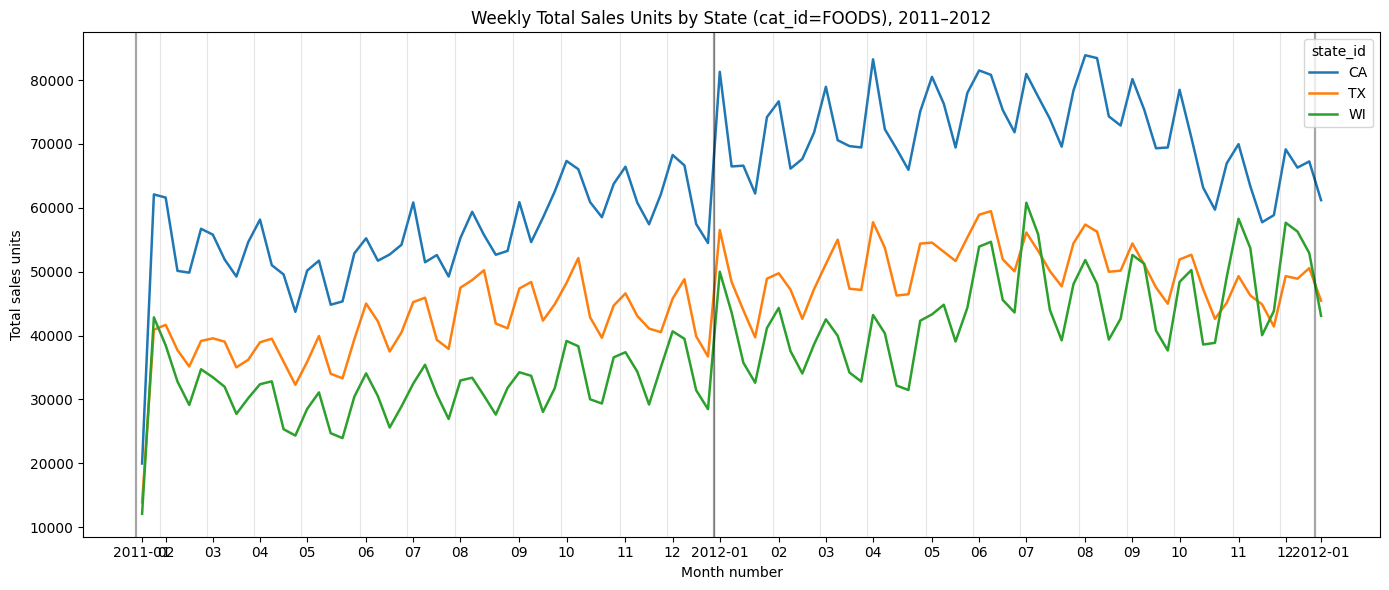

In [53]:
"""
From the new sales_backbone, help me generate the code to aggregate the total sales_unit per week, per cat_id, per state_id, and then help me plot a time series chart
of total sales units per week, each state_id has it's own line. For x-axis, I want the week to be 1, 2,3, to week 52 for each year from 2011 to 2016. I want a vertical line at each year end to separate the years.
"""
# Ensure date is datetime (calendar has "date" as YYYY-MM-DD)
sales_backbone["date"] = pd.to_datetime(sales_backbone["date"])

# Keep 2011–2016 and build a "week index" that goes 1..52 within each year
df = sales_backbone.loc[
    sales_backbone["date"].dt.year.between(2011, 2012),
    ["date", "cat_id", "state_id", "sales_unit"],
].copy()

df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week.astype(int)
df = df[df["week"] <= 52]  # keep week 1..52 only (drops ISO week 53 if present)

weekly = (
    df.groupby(["year", "week", "cat_id", "state_id"], as_index=False)["sales_unit"]
      .sum()
      .rename(columns={"sales_unit": "total_sales_unit"})
)

# Pick which cat_id to plot (set this to e.g. "HOBBIES", "FOODS", "HOUSEHOLD")
cat_to_plot = weekly["cat_id"].iloc[0]

plot_df = weekly[weekly["cat_id"] == cat_to_plot].copy()
plot_df["x"] = (plot_df["year"] - 2011) * 52 + plot_df["week"]  # continuous x across years

pivot = plot_df.pivot(index="x", columns="state_id", values="total_sales_unit").sort_index()

ax = pivot.plot(figsize=(14, 6), linewidth=1.8)
ax.set_title(f"Weekly Total Sales Units by State (cat_id={cat_to_plot}), 2011–2012")
ax.set_xlabel("Week (1..52 each year, 2011–2012)")
ax.set_ylabel("Total sales units")

# Year-end separators (after week 52 of each year)
for y in range(2011, 2012):  # lines between years (2011|2012 ... 2015|2016)
    ax.axvline((y - 2011) * 52 + 52 + 0.5, color="black", alpha=0.25, linewidth=1) 
    
# Build week->date calendar (week start date)
week_calendar = (
    df.groupby(["year", "week"], as_index=False)["date"].min()
      .rename(columns={"date": "week_start"})
)
week_calendar["x"] = (week_calendar["year"] - 2011) * 52 + week_calendar["week"]
week_calendar = week_calendar.sort_values("x")

# Month starts (week where month changes)
week_calendar["month"] = week_calendar["week_start"].dt.month
week_calendar["year2"] = week_calendar["week_start"].dt.year

month_starts = week_calendar.loc[
    week_calendar["month"].ne(week_calendar["month"].shift()),
    ["x", "year2", "month"],
]

# Vertical lines: light for month boundaries, bold for Jan (start-of-year)
for _, r in month_starts.iterrows():
    is_jan = int(r["month"]) == 1
    ax.axvline(
        r["x"] - 0.5,
        color="black" if is_jan else "gray",
        alpha=0.35 if is_jan else 0.20,
        linewidth=1.6 if is_jan else 0.8,
    )

# Month-start ticks/labels: show YYYY-01 at each January, else MM
ticks = month_starts["x"].tolist()
labels = [
    f"{int(y)}-01" if int(m) == 1 else f"{int(m):02d}"
    for y, m in zip(month_starts["year2"], month_starts["month"])
]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel("Month number")

ax.legend(title="state_id")
plt.tight_layout()
plt.show()

In [45]:
sales_backbone.columns

Index(['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id', 'd',
       'sales_unit', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sell_price_filled',
       'sales_unit_lag_1', 'sell_price_lag_1', 'sales_unit_lag_7',
       'sell_price_lag_7', 'sales_unit_lag_14', 'sell_price_lag_14',
       'sales_unit_lag_28', 'sell_price_lag_28', 'sales_unit_roll_mean_7',
       'sell_price_roll_mean_7', 'sales_unit_roll_mean_28',
       'sell_price_roll_mean_28'],
      dtype='object')

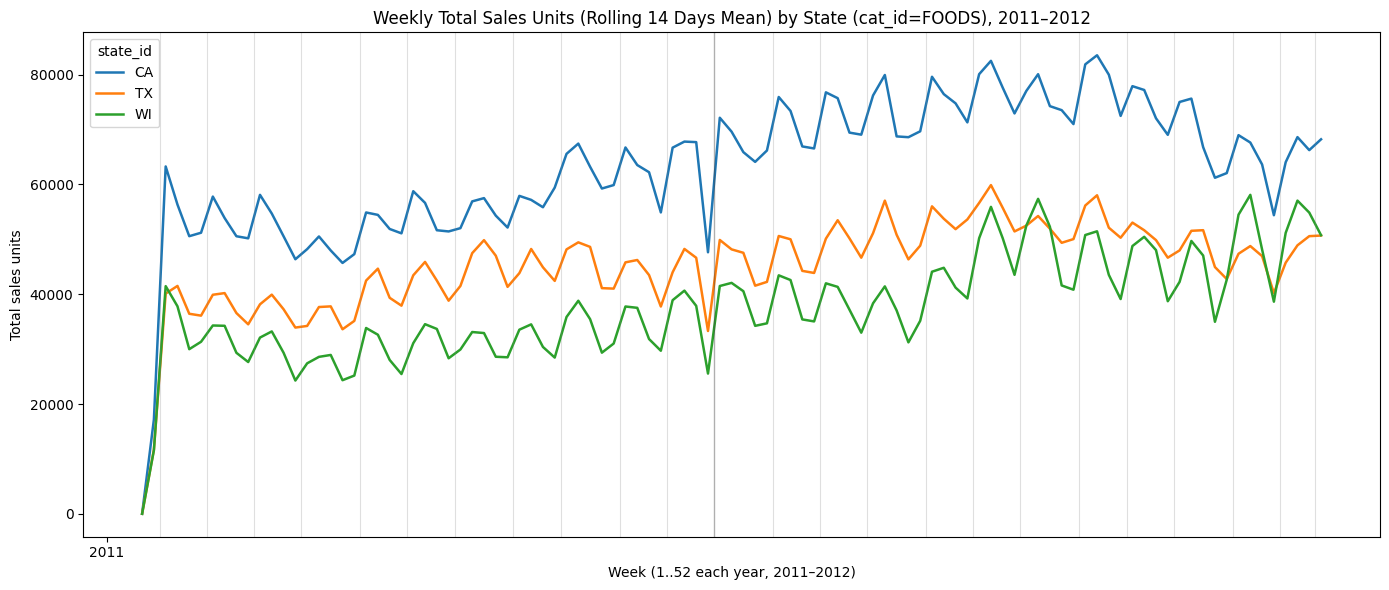

In [ ]:
# Ensure date is datetime (calendar has "date" as YYYY-MM-DD)
sales_backbone["date"] = pd.to_datetime(sales_backbone["date"])

# Keep 2011–2016 and build a "week index" that goes 1..52 within each year
df = sales_backbone.loc[
    sales_backbone["date"].dt.year.between(2011, 2012),
    ["date", "cat_id", "state_id", "sales_unit_roll_mean_7"],
].copy()

df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week.astype(int)
df = df[df["week"] <= 52]  # keep week 1..52 only (drops ISO week 53 if present)

weekly = (
    df.groupby(["year", "week", "cat_id", "state_id"], as_index=False)["sales_unit_roll_mean_7"]
      .sum()
      .rename(columns={"sales_unit_roll_mean_7": "total_sales_unit"})
)

# Pick which cat_id to plot (set this to e.g. "HOBBIES", "FOODS", "HOUSEHOLD")
cat_to_plot = weekly["cat_id"].iloc[0]

plot_df = weekly[weekly["cat_id"] == cat_to_plot].copy()
plot_df["x"] = (plot_df["year"] - 2011) * 52 + plot_df["week"]  # continuous x across years

pivot = plot_df.pivot(index="x", columns="state_id", values="total_sales_unit").sort_index()

ax = pivot.plot(figsize=(14, 6), linewidth=1.8)
ax.set_title(f"Weekly Total Sales Units (Rolling 7 Days Mean) by State (cat_id={cat_to_plot}), 2011–2012")
ax.set_xlabel("Week (1..52 each year, 2011–2012)")
ax.set_ylabel("Total sales units")
# Year-end separators (after week 52 of each year)
for y in range(2011, 2012):  # lines between years (2011|2012 ... 2015|2016)
    ax.axvline((y - 2011) * 52 + 52 + 0.5, color="black", alpha=0.25, linewidth=1) 

# Month boundary separators (approximate, since x is weekly)
week_calendar = (
    df.groupby(["year", "week"], as_index=False)["date"].min()
      .rename(columns={"date": "week_start"})
)
week_calendar["x"] = (week_calendar["year"] - 2011) * 52 + week_calendar["week"]
week_calendar = week_calendar.sort_values("x")
week_calendar["month"] = week_calendar["week_start"].dt.to_period("M")


month_starts = week_calendar.loc[
    week_calendar["month"].ne(week_calendar["month"].shift()),
    ["x", "month"],
].iloc[1:]  # skip first month

for x in month_starts["x"]:
    ax.axvline(x - 0.5, color="gray", alpha=0.25, linewidth=0.8)

# Optional: nicer x ticks (show year labels at start of each year)
xticks = [(y - 2011) * 52 + 1 for y in range(2011, 2012)]
ax.set_xticks(xticks)
ax.set_xticklabels([str(y) for y in range(2011, 2012)], rotation=0)

ax.legend(title="state_id")
plt.tight_layout()
plt.show()

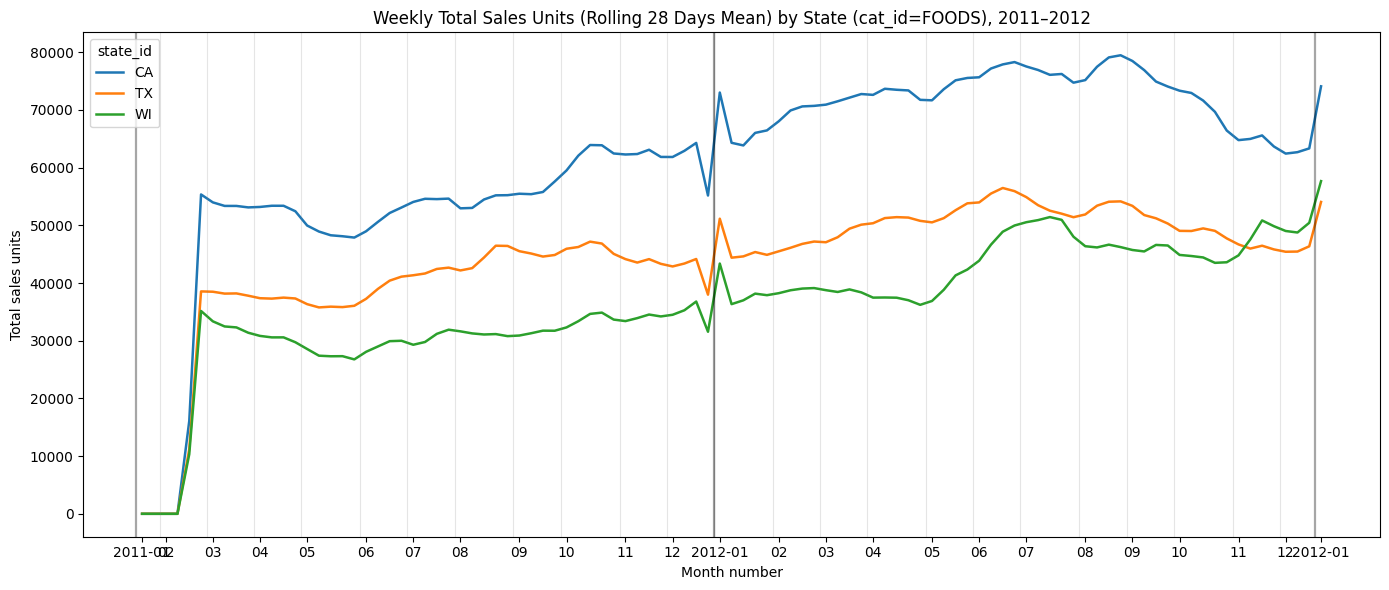

In [52]:
# Ensure date is datetime (calendar has "date" as YYYY-MM-DD)
sales_backbone["date"] = pd.to_datetime(sales_backbone["date"])

# Keep 2011–2016 and build a "week index" that goes 1..52 within each year
df = sales_backbone.loc[
    sales_backbone["date"].dt.year.between(2011, 2012),
    ["date", "cat_id", "state_id", "sales_unit_roll_mean_28"],
].copy()

df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week.astype(int)
df = df[df["week"] <= 52]  # keep week 1..52 only (drops ISO week 53 if present)

weekly = (
    df.groupby(["year", "week", "cat_id", "state_id"], as_index=False)["sales_unit_roll_mean_28"]
      .sum()
      .rename(columns={"sales_unit_roll_mean_28": "total_sales_unit"})
)

# Pick which cat_id to plot (set this to e.g. "HOBBIES", "FOODS", "HOUSEHOLD")
cat_to_plot = weekly["cat_id"].iloc[0]

plot_df = weekly[weekly["cat_id"] == cat_to_plot].copy()
plot_df["x"] = (plot_df["year"] - 2011) * 52 + plot_df["week"]  # continuous x across years

pivot = plot_df.pivot(index="x", columns="state_id", values="total_sales_unit").sort_index()

ax = pivot.plot(figsize=(14, 6), linewidth=1.8)
ax.set_title(f"Weekly Total Sales Units (Rolling 28 Days Mean) by State (cat_id={cat_to_plot}), 2011–2012")
ax.set_xlabel("Week (1..52 each year, 2011–2012)")
ax.set_ylabel("Total sales units")

# Year-end separators (after week 52 of each year)
for y in range(2011, 2012):  # lines between years (2011|2012 ... 2015|2016)
    ax.axvline((y - 2011) * 52 + 52 + 0.5, color="black", alpha=0.25, linewidth=1) 
    
# Build week->date calendar (week start date)
week_calendar = (
    df.groupby(["year", "week"], as_index=False)["date"].min()
      .rename(columns={"date": "week_start"})
)
week_calendar["x"] = (week_calendar["year"] - 2011) * 52 + week_calendar["week"]
week_calendar = week_calendar.sort_values("x")

# Month starts (week where month changes)
week_calendar["month"] = week_calendar["week_start"].dt.month
week_calendar["year2"] = week_calendar["week_start"].dt.year

month_starts = week_calendar.loc[
    week_calendar["month"].ne(week_calendar["month"].shift()),
    ["x", "year2", "month"],
]

# Vertical lines: light for month boundaries, bold for Jan (start-of-year)
for _, r in month_starts.iterrows():
    is_jan = int(r["month"]) == 1
    ax.axvline(
        r["x"] - 0.5,
        color="black" if is_jan else "gray",
        alpha=0.35 if is_jan else 0.20,
        linewidth=1.6 if is_jan else 0.8,
    )

# Month-start ticks/labels: show YYYY-01 at each January, else MM
ticks = month_starts["x"].tolist()
labels = [
    f"{int(y)}-01" if int(m) == 1 else f"{int(m):02d}"
    for y, m in zip(month_starts["year2"], month_starts["month"])
]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel("Month number")

ax.legend(title="state_id")
plt.tight_layout()
plt.show()